# News articles classifier 

We use word vector representations to build a classifier of news. 


#### Outline
1. We start with a baseline model (News_classifierV1) using word embeddings.
2. We build a more sophisticated model (News_classifierV2) that incorporates an LSTM. 

In [1]:
import numpy as np
import sklearn
from sklearn.utils import shuffle
import re
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

## 1 - Preparing the dataset

### 1.1 - Dataset description

We want to create a dataset (X, Y) where:
- X is an array containing 2225 strings (the titles of the BBC articles).
- Y is an array of shape (2225,) and contains an integer label between 0 and 4 corresponding to the categories:
    * 0: Business
    * 1: Entertainment
    * 2: Politics
    * 3: Sport
    * 4: Tech


Let's load the dataset.

In [2]:
import os

n_articles = 2225

## We first declare X as a list, and then will turn it into an array
X = []
Y = np.zeros((n_articles,), dtype=int)

directory = ['data/business', 'data/entertainment', 'data/politics', 'data/sport', 'data/tech']
idx=0

for i in range(5):
    for filename in os.listdir(directory[i]):
        f = open(directory[i] + '/' + filename, errors='replace')
        first_line = f.readline()
        X.append(first_line)
        Y[idx] = i
        idx = idx+1

## We make the list X into an array X
X = np.array(X)

Let's take a look at the first few examples:

In [3]:
for idx in range(5):
    print(X[idx], label_to_category(Y[idx]))

UK economy facing 'major risks'
 [Business]
Aids and climate top Davos agenda
 [Business]
Asian quake hits European shares
 [Business]
India power shares jump on debut
 [Business]
Lacroix label bought by US firm
 [Business]


### 1.2 - Cleaning the data

The main problem we may encounter is that some words appearing in the input strings are not present in our GloVe vocabulary. We decide to solve this isssue by simply removing these words from the input strings. Moreover, we remove any special characters and numbers and make all strings lowercase.

First, let's load the vocabulary as a list `word_list` 

In [4]:
## Get word list (vocabulary) from Glove file
with open('data/glove.6B.50d.txt') as f:
    text = f.readlines()

word_list = [line.strip().split()[0] for line in text]

print('Our vocabulary contains', len(word_list), 'words.')

Our vocabulary contains 400000 words.


Now we normalize the text and print all words that are not present in the vocabulary.

In [5]:
## Remove numbers and special characters and set lowercase
for i in range(n_articles):
    X[i] = re.sub('[^A-Za-z ]+', ' ', X[i]).lower()
    # remove whitespace from the beginning and end
    X[i] = X[i].strip()
        
    # Print all words NOT in the vocabulary
    for word in X[i].split() :
        if not word in word_list :
            print(i, word)

13 phytopharm
176 illva
483 colludes
700 mccririck
823 holiff
992 oaps
1178 truanted
1368 brizzel
1910 blinx
1912 gigapixel
2010 dialler
2123 robotiquette


Since we are dealing with only a few exceptions, we decide to simply remove  these words.

In [6]:
for i in range(n_articles):
    for word in X[i].split() :
        if not word in word_list :
            X[i] = X[i].replace(word, '')

Let's take an overview of this dataset and the distribution of data

In [7]:
Y0, Y1, Y2, Y3, Y4 = np.count_nonzero(Y == 0), np.count_nonzero(Y == 1), np.count_nonzero(Y == 2), np.count_nonzero(Y == 3), np.count_nonzero(Y == 4)

print('Number of Titles (lenght of X): ', len(X), '\n' 
'Number of Titles labelled Buiseness: ', Y0, '\n'
'Number of Titles labelled Entertainment: ', Y1, '\n'     
'Number of Titles labelled Politics: ', Y2, '\n'     
'Number of Titles labelled Sport: ', Y3, '\n'     
'Number of Titles labelled Tech: ', Y4, '\n'
'Total number of labelled Titles: ', Y0+Y1+Y2+Y3+Y4, '\n')

Number of Titles (lenght of X):  2225 
Number of Titles labelled Buiseness:  510 
Number of Titles labelled Entertainment:  386 
Number of Titles labelled Politics:  417 
Number of Titles labelled Sport:  511 
Number of Titles labelled Tech:  401 
Total number of labelled Titles:  2225 



### 1.3 - Training and Test set

We observe that the dataset is quite balanced with respect to the 5 categories.

We shuffle the dataset and split it between training (2025 examples) and testing (200 examples).

In [8]:
m = 2025

X, Y = shuffle(X, Y)

X_train, Y_train = X[:m], Y[:m]
X_test, Y_test = X[m:], Y[m:]

In [9]:
maxLen = len(max(X_train, key=len).split())

Let's print some examples from the training set.

In [10]:
for idx in range(10):
    print(X_train[idx], label_to_category(Y_train[idx]))

fresh hope after argentine crisis [Business]
umaga ready for lions [Sport]
bond game fails to shake or stir [Tech]
blair stresses prosperity goals [Politics]
dawson joins england injury list [Sport]
beckham rules out management move [Sport]
mobile tv tipped as one to watch [Tech]
blind student  hears in colour [Tech]
ford gains from finance not cars [Business]
us peer to peer pirates convicted [Tech]


## 2 - Building the baseline model


#### Inputs and outputs
* The input of the model is a string corresponding to a sentence.
* The output will be a probability vector of shape (1,5), as there are 5 categories.
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the category with the highest probability.

#### One-hot encoding
To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$.

In [11]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

### 2.1 - Implementing News_classifierV1

First step:
* Convert each word in the input sentence into their word vector representations.
* Then take an average of the word vectors. 

Let's load the `word_to_vec_map`, which contains all the vector representations.

In [12]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

Description:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

As an example:

In [13]:
word = "hasard"
idx = 259826
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of hasard in the vocabulary is 174049
the 259826th word in the vocabulary is neurotrophic


We now implement `sentence_to_avg()` function

In [14]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector
    avg = np.zeros(50,)
    
    # Average the word vectors
    total = 0
    for w in words:
        total += word_to_vec_map[w]
    avg = total / len(words)
        
    return avg

#### Model

We now implement the `model()` function. 
After using `sentence_to_avg()` we have 3 steps:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

In [15]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 500):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Define number of training examples
    m = Y.shape[0]      # number of training examples
    n_y = 5             # number of classes  
    n_h = 50            # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost
            cost = -1*np.dot(Y_oh, np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in utils.py

    return pred, W, b

We train the model and learn the softmax parameters (W,b). 

In [16]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = [1.6217858  0.85731537 2.36928049 ... 0.85731537 0.85731537 1.66189324]
Accuracy: 0.8069135802469136
Epoch: 100 --- cost = [2.90939102 0.46946452 2.47849159 ... 0.46946452 0.46946452 1.75280549]
Accuracy: 0.8790123456790123
Epoch: 200 --- cost = [2.84056356 0.48392548 2.44812798 ... 0.48392548 0.48392548 1.67054283]
Accuracy: 0.8790123456790123
Epoch: 300 --- cost = [2.81939172 0.49315361 2.45239485 ... 0.49315361 0.49315361 1.63121982]
Accuracy: 0.8809876543209877
Epoch: 400 --- cost = [2.81114757 0.50087805 2.45912886 ... 0.50087805 0.50087805 1.60643082]
Accuracy: 0.8819753086419753
[[0.]
 [3.]
 [4.]
 ...
 [3.]
 [3.]
 [3.]]


### 2.2 - Examining test set performance 

In [17]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.8819753086419753
Test set:
Accuracy: 0.855


#### Confusion matrix
Let us try to understand which classes are more difficult for this model by plotting a confusion matrix. 

(200,)
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0           41    0    4    1    1   47
1            1   24    0    0    1   26
2            1    0   29    1    1   32
3            0    1    2   56    1   60
4            4    5    4    1   21   35
All         47   30   39   59   25  200


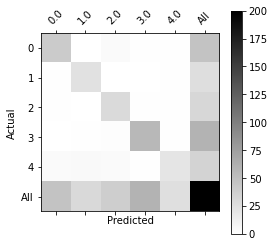

In [18]:
print(Y_test.shape)
print(pd.crosstab(Y_test, pred_test.reshape(200,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

It looks like the main mistake is confusion between 'Business' (class 0) and 'Politics' (class 2) -- not so surprising even for human-level performance!

## 2 - News_classifierV2 using LSTMs in Keras

Let's build an LSTM model that takes word **sequences** as input.
* This model will be able to account for the word ordering. 
* News_classifierV2 will continue to use pre-trained word embeddings to represent words.
* We will feed word embeddings into an LSTM.
* The LSTM will learn to predict the most appropriate category. 

In [19]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

### 2.1 - The Embedding layer


#### Inputs and outputs to the embedding layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).


#### Prepare the input sentences
* We implement `sentences_to_indices`, which processes an array of sentences (X) and returns inputs to the embedding layer:
    * Convert each training sentences into a list of indices (the indices correspond to each word in the sentence)
    * Zero-pad all these lists so that their length is the length of the longest sentence.

In [20]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]  # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert ith training sentence in lower case and split it into words; get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            j = j + 1
                
    return X_indices

#### Build embedding layer

* Let's build the `Embedding()` layer in Keras, using pre-trained word vectors. 
* The embedding layer takes as input a list of word indices: `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence. 

We implement `pretrained_embedding_layer()` with these steps:
1. Initialize the embedding matrix as a numpy array of zeros.
2. Fill in each row of the embedding matrix with the vector representation of a word
3. Define the Keras embedding layer. Note:
    * Setting `trainable = True`, will allow the optimization algorithm to modify the values of the word embeddings. In this case, we don't want the model to modify the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix.

In [21]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

### 2.2 Building the Model

Let's now build the News_classifierV2 model.

In [22]:
def News_classifierV2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    
    return model

**Model Summary**

In [23]:
model = News_classifierV2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 9, 50)             20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 9, 128)            91648     
_________________________________________________________________
dropout (Dropout)            (None, 9, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

#### Compile and train the model
Compile model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

News_classifierV2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [25]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [26]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
64/64 [==============================] - 6s 34ms/step - loss: 1.1746 - accuracy: 0.5719
Epoch 2/50
64/64 [==============================] - 2s 31ms/step - loss: 0.4918 - accuracy: 0.8464 1s -
Epoch 3/50
64/64 [==============================] - 1s 16ms/step - loss: 0.4024 - accuracy: 0.8671
Epoch 4/50
64/64 [==============================] - 1s 15ms/step - loss: 0.3444 - accuracy: 0.8867
Epoch 5/50
64/64 [==============================] - 1s 15ms/step - loss: 0.3158 - accuracy: 0.9069
Epoch 6/50
64/64 [==============================] - 1s 15ms/step - loss: 0.2915 - accuracy: 0.9036
Epoch 7/50
64/64 [==============================] - 1s 15ms/step - loss: 0.2432 - accuracy: 0.9187
Epoch 8/50
64/64 [==============================] - 1s 15ms/step - loss: 0.2227 - accuracy: 0.9287
Epoch 9/50
64/64 [==============================] - 1s 15ms/step - loss: 0.1937 - accuracy: 0.9443
Epoch 10/50
64/64 [==============================] - 1s 15ms/step - loss: 0.1585 - accuracy: 0.9488
Epoc

### 2.3 - Model evaluation


#### Evaluate model on the test set

In [27]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

7/7 [==============================] - 1s 8ms/step - loss: 0.6690 - accuracy: 0.8950

Test accuracy =  0.8949999809265137


Let us look at the mislabelled examples. 

In [28]:
# Print the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected category'+ label_to_category(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_category(num).strip())

Expected category[Entertainment] prediction: wife swap makers sue us  copycat[Business]
Expected category[Tech] prediction: cabs collect mountain of mobiles[Business]
Expected category[Tech] prediction: ea to take on film and tv giants[Entertainment]
Expected category[Entertainment] prediction: da vinci code is  lousy history[Tech]
Expected category[Tech] prediction: warning over tsunami aid website[Entertainment]
Expected category[Tech] prediction: gates opens biggest gadget fair[Entertainment]
Expected category[Politics] prediction: ministers  naive  over phone taps[Tech]
Expected category[Entertainment] prediction: new media battle for bafta awards[Tech]
Expected category[Business] prediction: ban on forced retirement under[Politics]
Expected category[Business] prediction: kraft cuts snack ads for children[Politics]
Expected category[Tech] prediction: bush website blocked outside us[Politics]
Expected category[Tech] prediction: halo fans  hope for sequel[Entertainment]
Expected cate

## Acknowledgments

* This work is based on what I learned from Coursera's Machine Learning Specialization by Andrew Ng and in particular uses code taken by the assignments I completed for the course on Sequence Models. 
* I used a (Public Domain) pretrained GloVe word embedding representation, dowloadable <a href="https://www.kaggle.com/watts2/glove6b50dtxt">here</a>.
* BBC Dataset: D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.
